In [1]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from dotenv import load_dotenv
import seaborn as sns

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [2]:
if not os.path.isdir('./charts'): os.mkdir("charts")

### Расчет метрик

In [3]:
visitors = pd.DataFrame(resp_visits.json())
regs = pd.DataFrame(resp_regs.json())

#Последние посещения с удалением дублей и преобразованием дат
visitors['datetime'] = pd.to_datetime(visitors['datetime']).dt.date
df_last_visit = visitors.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset=['visit_id'], keep='last')

#Исключение ботов из визитов и подсчёт количества посещений
filtered_visits = df_last_visit[~df_last_visit['user_agent'].str.contains('bot', case=False)]

platform_visits_count = filtered_visits.groupby(['datetime', 'platform']).agg(visits_count=('visit_id', 'count')).reset_index()
platform_visits_count.columns = ['date_group','platform','visits']


#Последние регистрации с удалением дублей и преобразованием дат
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date
df_sorted_regs = regs.sort_values(by='datetime')
df_without_duplicates = df_sorted_regs.drop_duplicates()

#Подсчёт количества регистраций
platform_regs_count = df_without_duplicates.groupby(['datetime', 'platform']).agg(registrations_count=('user_id', 'count')).reset_index()
platform_regs_count.columns = ['date_group','platform','registrations']


#Объеденение датайфреймов и расчет конверсии
united_conversion = platform_visits_count.merge(platform_regs_count, on=['date_group','platform'], how='left')
united_conversion.sort_values(by=['date_group', 'platform'], inplace=True)
united_conversion = united_conversion.reset_index(drop=True)
united_conversion.fillna(0, inplace=True)

def calculate_conversion(df, target_column, total_column):
      conversion = (df[target_column] / df[total_column]) * 100
      return conversion

conversion = calculate_conversion(united_conversion, 'registrations', 'visits')

united_conversion['conversion'] = conversion
united_conversion.to_json('./conversion.json')

#Общая конверсия
tot_conversion= united_conversion.groupby('date_group', as_index=False).sum()
conversions_tot = calculate_conversion(tot_conversion, 'registrations', 'visits')
tot_conversion['conversion'] = conversions_tot
tot_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,androidiosweb,376,87,23.138298
1,2023-03-02,androidiosweb,613,106,17.292007
2,2023-03-03,androidiosweb,683,107,15.666179
3,2023-03-04,androidiosweb,647,159,24.574961
4,2023-03-05,androidiosweb,707,115,16.265912


### Добавление рекламных компаний

In [15]:
ads = pd.read_csv("./ads.csv")

#Преобразование дат
ads = ads[(ads['date'] >= DATE_BEGIN) & (ads['date'] <= DATE_END)]
ads['date'] = pd.to_datetime(ads['date']).dt.date
ads = ads.fillna({'utm_campaign': 'none', 'cost': 0})


#Объеденение рекламных компаний с конверсией и обработка пропусков
ads_merged = pd.merge( united_conversion, ads, left_on='date_group', right_on='date')
ads_merged.sort_values(by='date_group', inplace=True)
ads_merged = ads_merged[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads_merged.to_json('./ads.json')

#Даты начала и конца рекламных компаний
min_dates = ads_merged.groupby('utm_campaign')['date_group'].min().reset_index(name='min_date_group')
max_dates = ads_merged.groupby('utm_campaign')['date_group'].max().reset_index(name='max_date_group')

ads_merged= ads_merged.merge(min_dates, on='utm_campaign', how='left')
ads_merged= ads_merged.merge(max_dates, on='utm_campaign', how='left')

ads_merged.head()

,date_group,visits,registrations,cost,utm_campaign,min_date_group,max_date_group
0,2023-03-01,75,61,212,advanced_algorithms_series,2023-03-01,2023-03-15
1,2023-03-01,22,18,212,advanced_algorithms_series,2023-03-01,2023-03-15
2,2023-03-01,279,8,212,advanced_algorithms_series,2023-03-01,2023-03-15
3,2023-03-02,67,59,252,advanced_algorithms_series,2023-03-01,2023-03-15
4,2023-03-02,31,24,252,advanced_algorithms_series,2023-03-01,2023-03-15


### График итоговых визитов

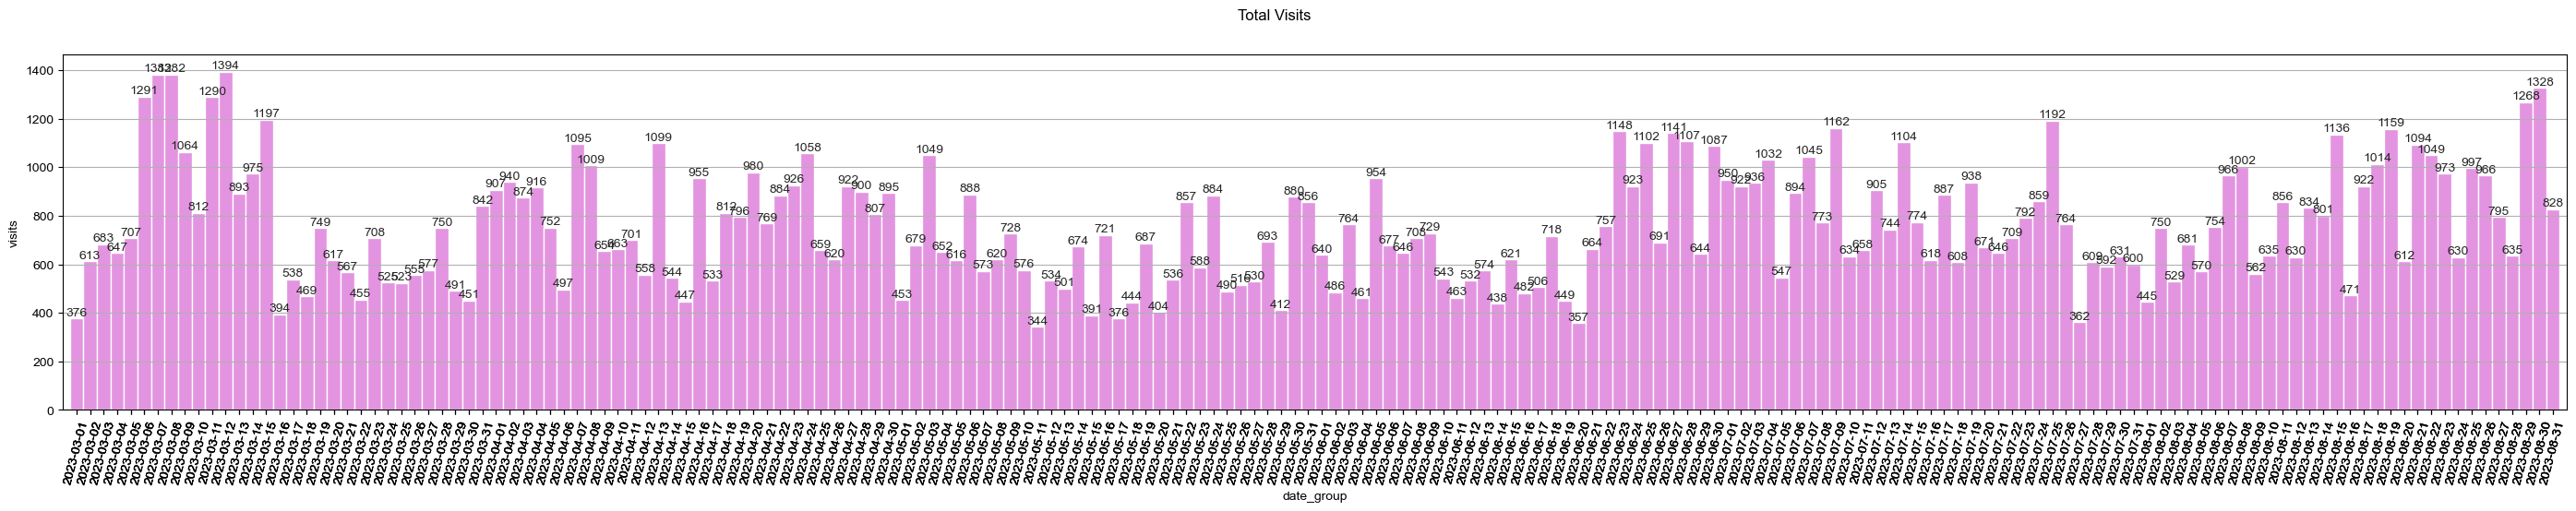

In [5]:
grouped_visitors = filtered_visits.groupby(['datetime', 'platform']).agg(visits_count=('visit_id', 'count')).reset_index()

min_date = grouped_visitors['datetime'].min()
max_date = grouped_visitors['datetime'].max()
offset_days = pd.Timedelta(days=1)
start_date = min_date - offset_days
end_date = max_date + offset_days

fig, ax = plt.subplots()
fig.set_size_inches((35, 5))
fig.suptitle("Total Visits")
ax.grid(axis='y')
sns.set_style("white")

ax = sns.histplot(x="datetime", data=filtered_visits, color='orchid')
ax.set_xlim(left=start_date, right=end_date)
ax.set_xticks(grouped_visitors['datetime'])

plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('visits')

ax.bar_label(ax.containers[0])
plt.savefig('./charts/total_visits.png')

### График итоговых визитов с разбивкой по платформе

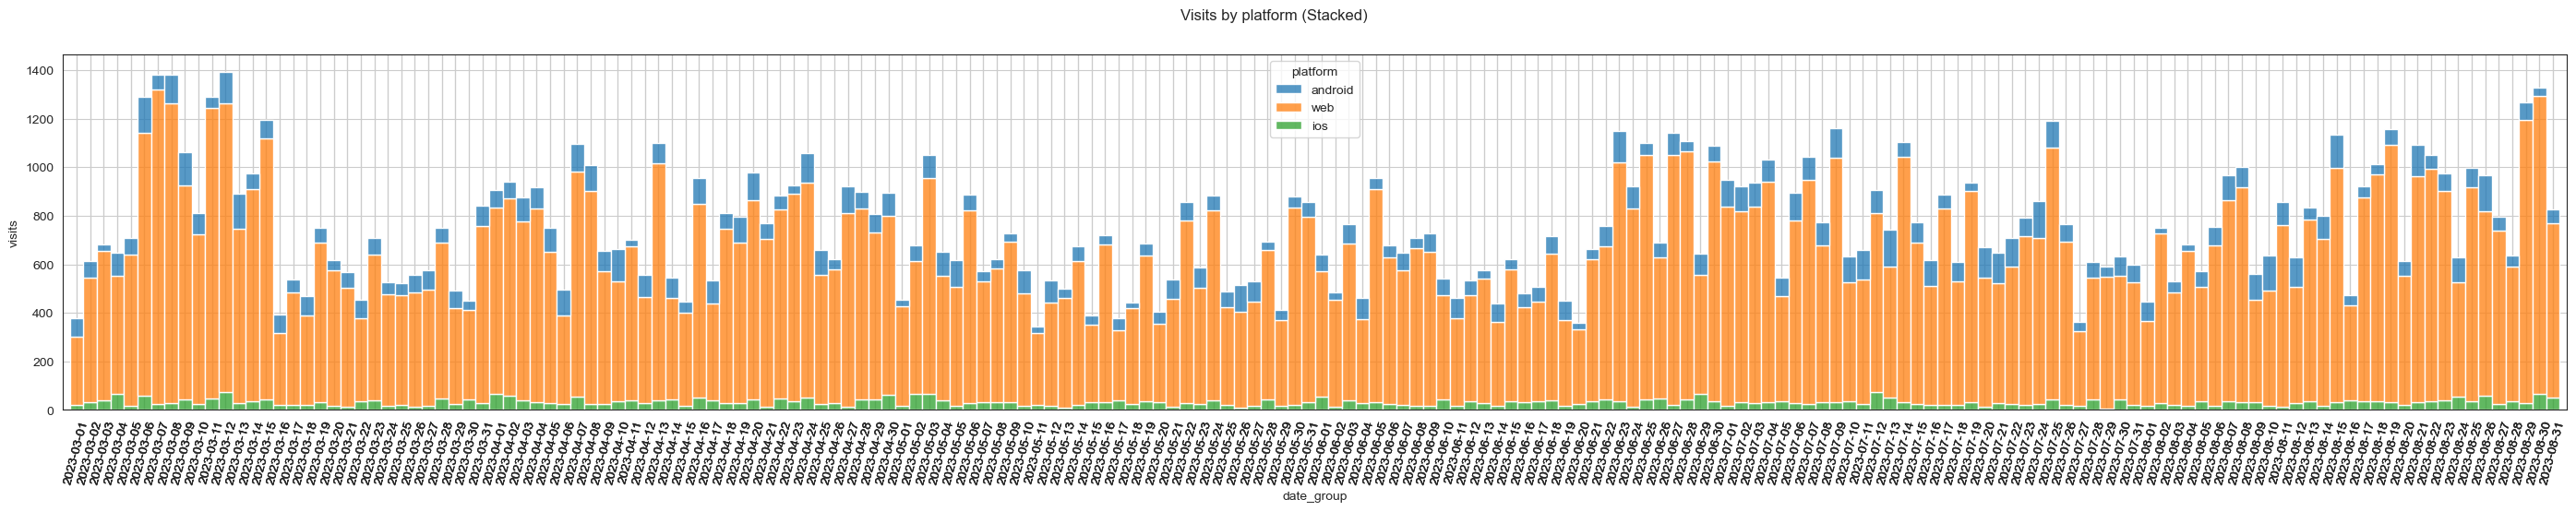

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches((35, 5))
fig.suptitle("Visits by platform (Stacked)")

ax.grid()
ax = sns.histplot(data=filtered_visits, x="datetime", hue='platform', multiple='stack')
ax.set_xlim(left=start_date, right=end_date)
ax.set_xticks(grouped_visitors['datetime'])

plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation = 75)
plt.savefig('./charts/visitors_by_platform.png')

### График итоговых регистраций

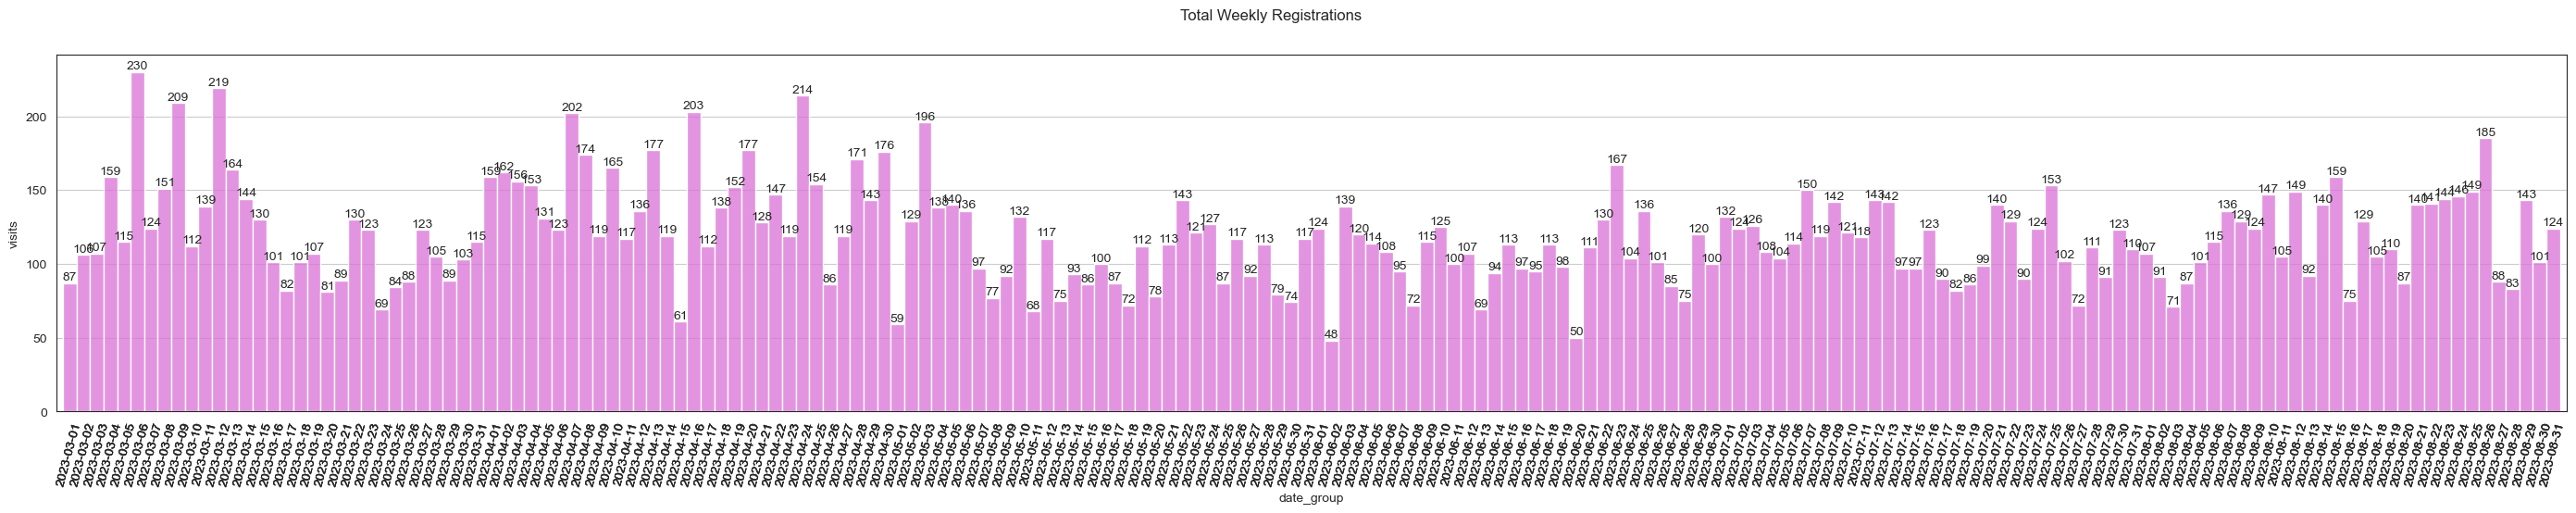

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches((35, 5))
fig.suptitle("Total Weekly Registrations")
ax.grid(axis='y')
sns.set_style("white")

ax = sns.histplot(x="datetime", data=df_without_duplicates, color='orchid')
ax.set_xlim(left=start_date, right=end_date)
ax.set_xticks(platform_regs_count['date_group'])

plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('visits')

ax.bar_label(ax.containers[0])
plt.savefig('./charts/total_regs.png')

### Итоговые регистрации с разбивкой по платформе

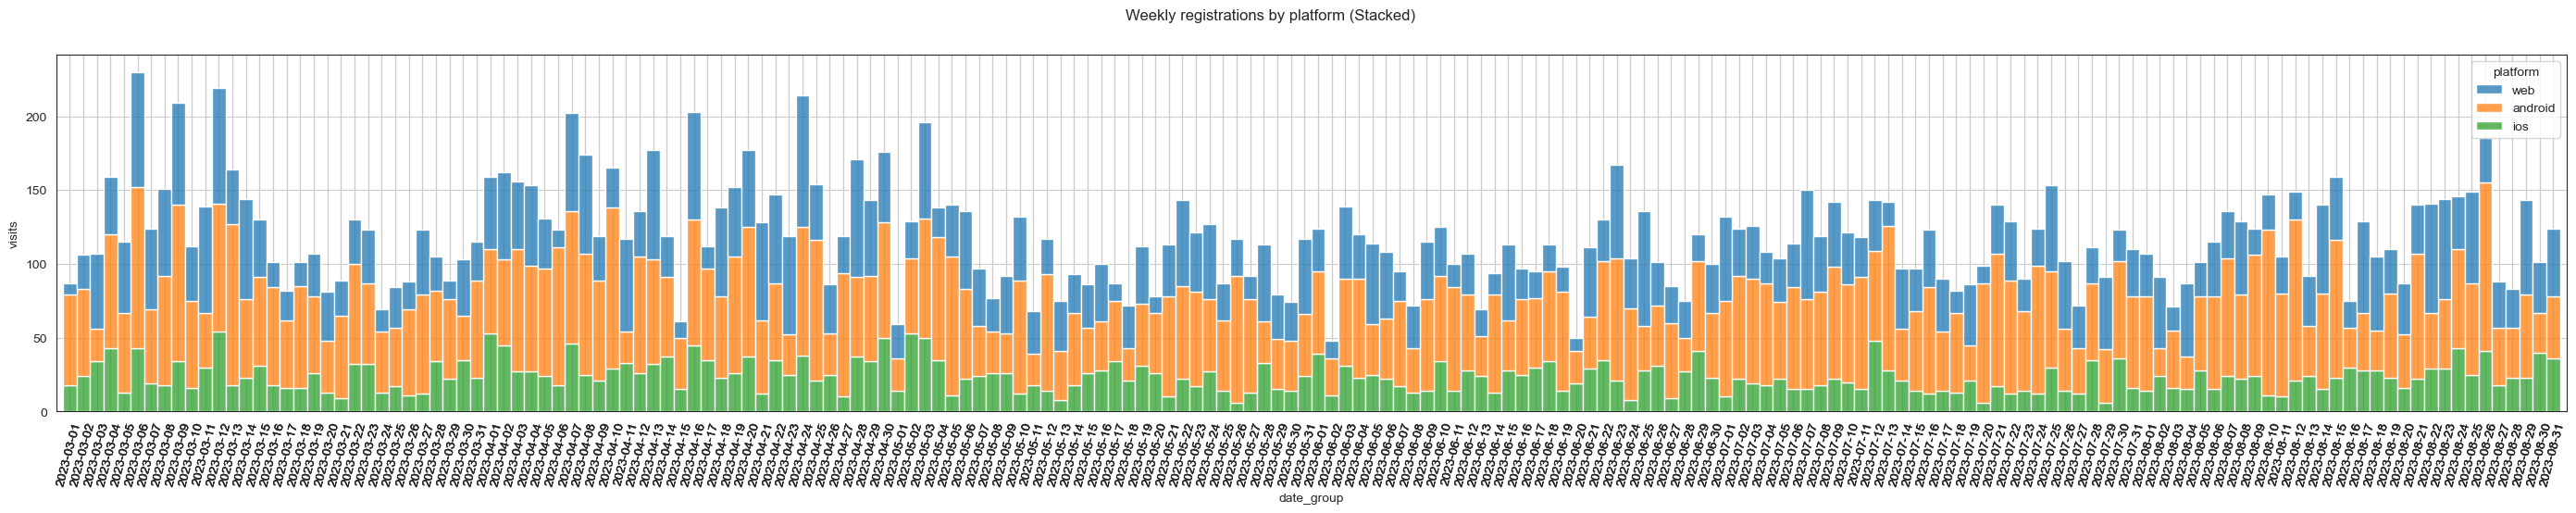

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches((35, 5))
fig.suptitle("Weekly registrations by platform (Stacked)")

ax.grid()
ax = sns.histplot(data=df_without_duplicates, x="datetime", hue='platform', multiple='stack')
ax.set_xlim(left=start_date, right=end_date)
ax.set_xticks(platform_regs_count['date_group'])

plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation = 75)
plt.savefig('./charts/registrations_by_platform.png')

### График полной конверсии

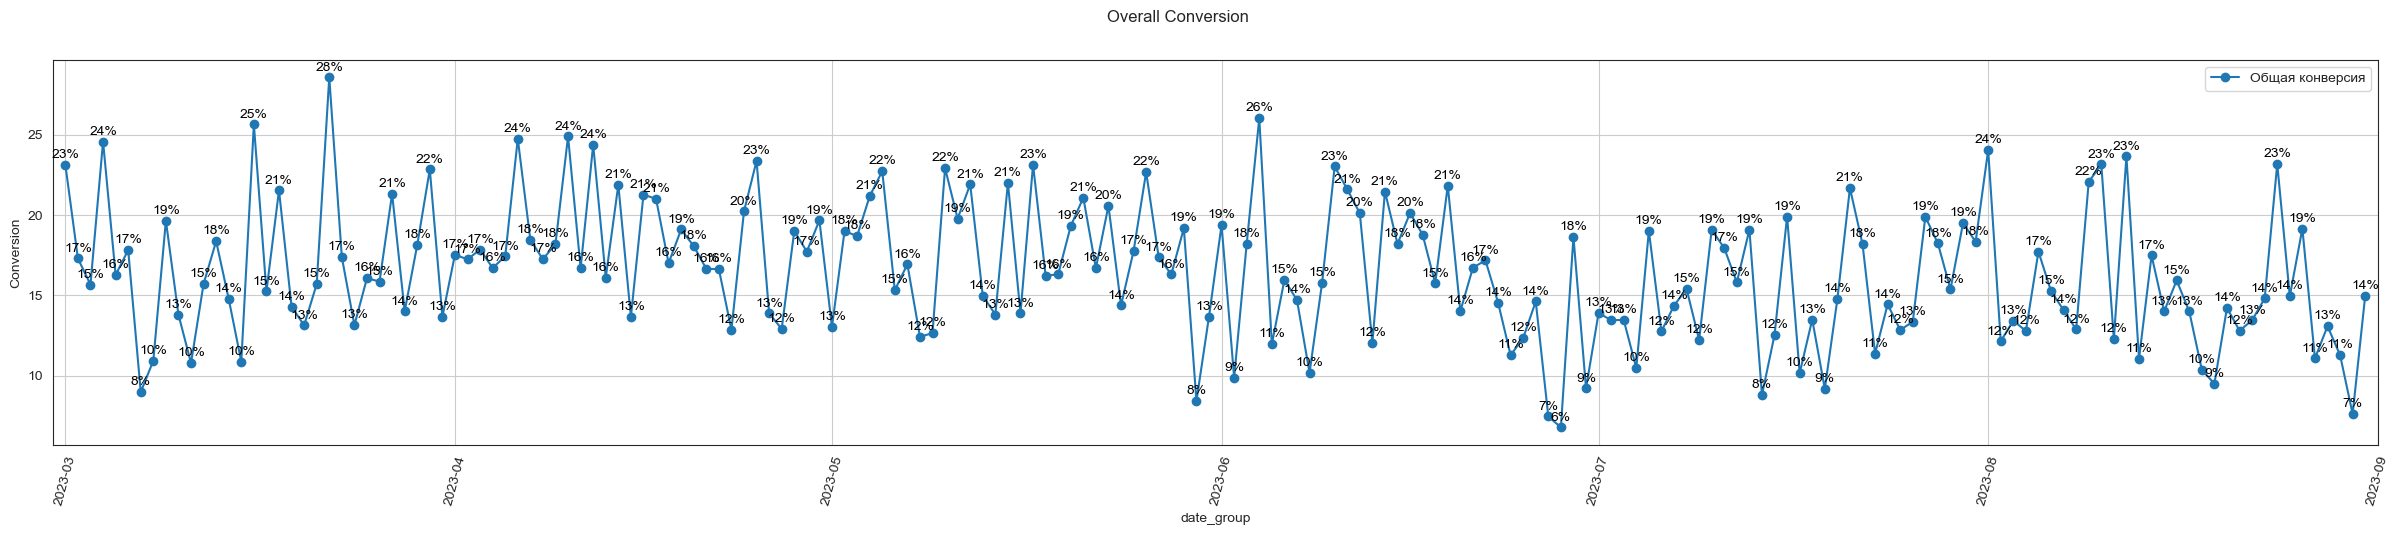

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches((30, 5))
fig.suptitle("Overall Conversion")
x = tot_conversion['date_group']
y = tot_conversion['conversion']
ax.plot(x,y, data=tot_conversion, marker='o', label='Общая конверсия')
ax.set_xlim(left=start_date, right=end_date)
ax.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion')
plt.xticks(rotation = 75)
for index, row in tot_conversion.iterrows():
    ax.annotate(
        text=f"{int(row['conversion'])}%",
        xy=(row['date_group'], row['conversion']),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        color='black'
    )
plt.legend()
plt.savefig('./charts/total_conversion.png')

### Графики конверсий по каждой платформе

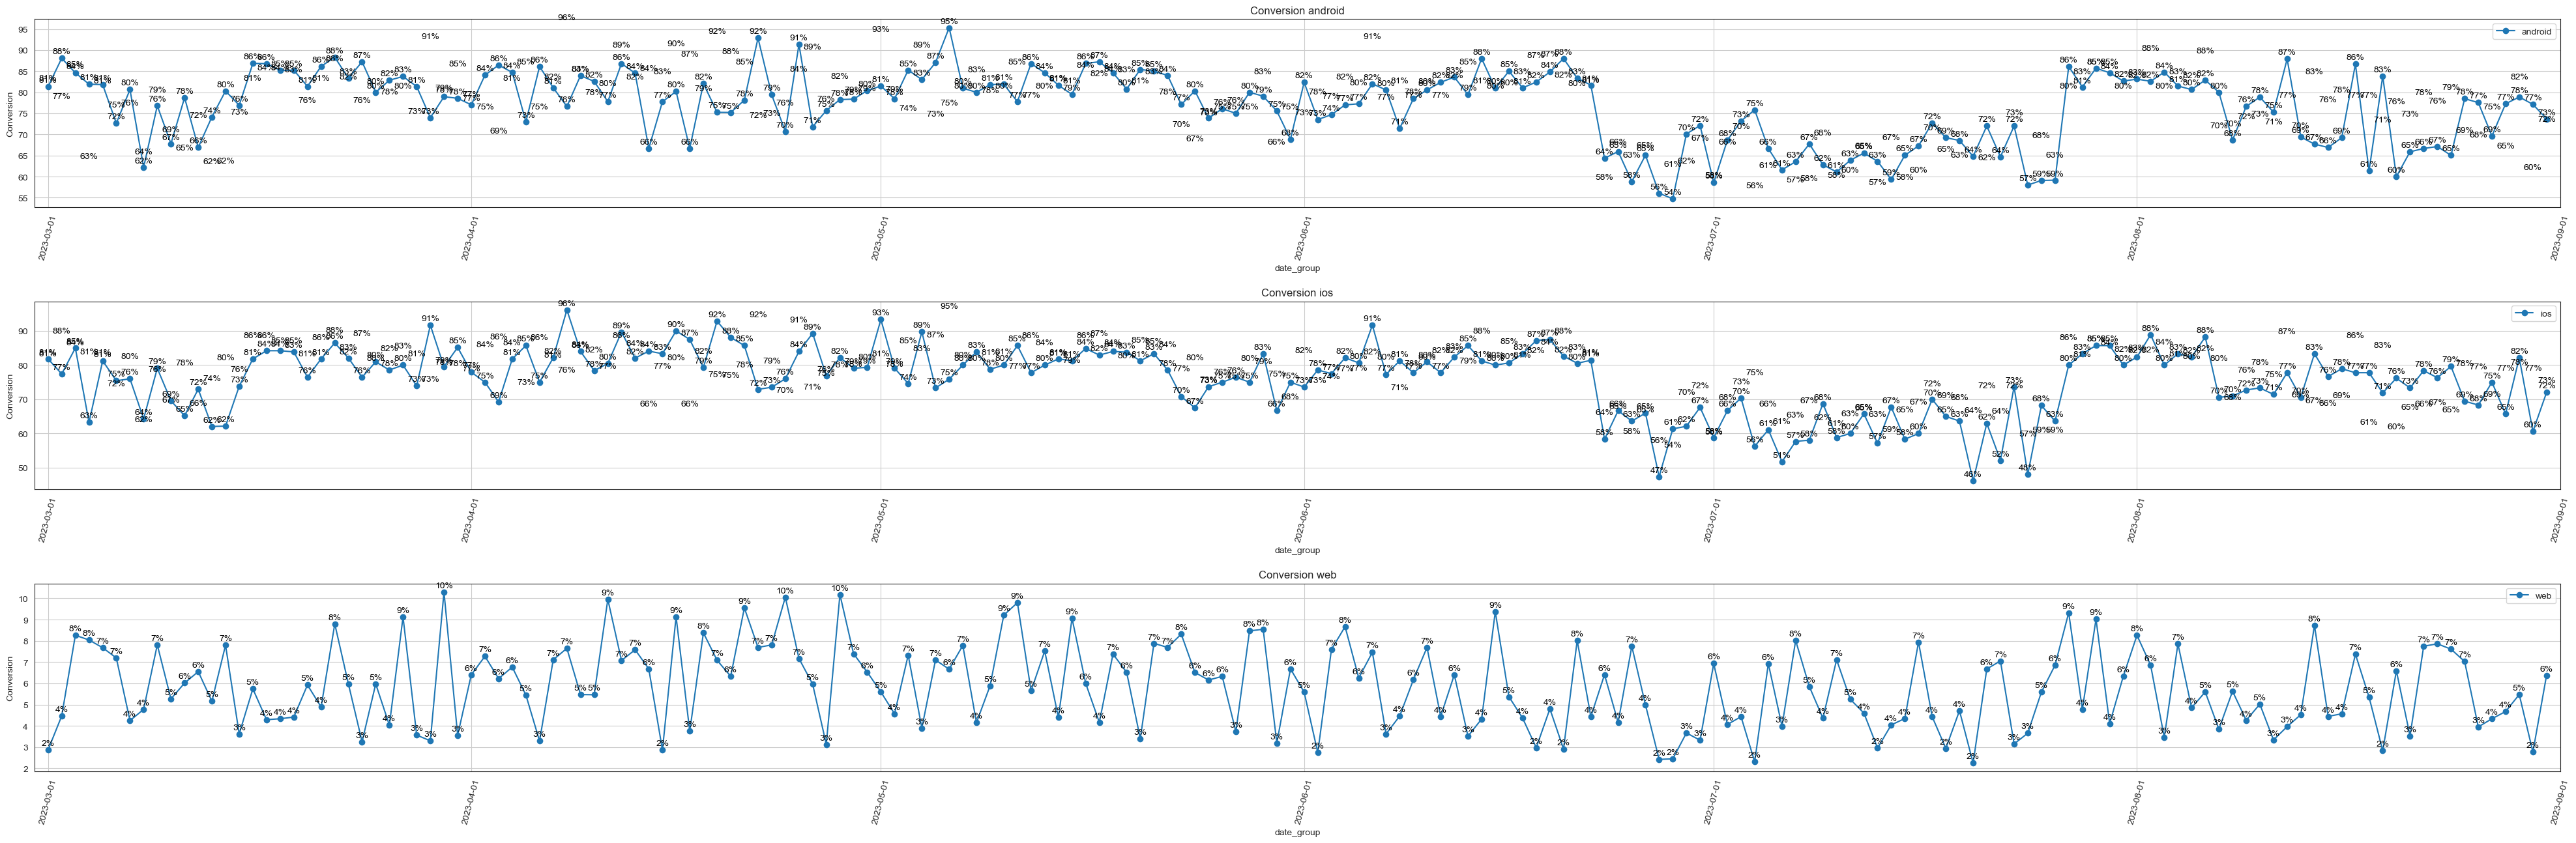

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((50, 15))

for n in range(3):
    platform = united_conversion[united_conversion['platform'] == united_conversion.platform[n]]
    platform_label= united_conversion.platform[n]
    platform_title= f'{'Conversion'} {united_conversion.platform[n]}'
    x = 'date_group'
    y = 'conversion'
    ax[n].plot(x, y, data=platform, label=platform_label, marker='o')
    ax[n].set_xlabel('date_group')
    ax[n].set_ylabel('Conversion')
    ax[n].set_title(platform_title)
    ax[n].set_xticks(ax[n].get_xticks())
    ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=75)
    ax[n].set_xlim(left=start_date, right=end_date)
    ax[n].legend()
    ax[n].grid()
    
    for index, row in united_conversion.iterrows():
        ax[n].annotate(
            text=f"{int(row['conversion'])}%",
            xy=(row['date_group'], row['conversion']),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            color='black'
        )
plt.subplots_adjust(hspace = 0.5)
plt.savefig('./charts/conversion_by_platform.png')

### График стоимости реклам

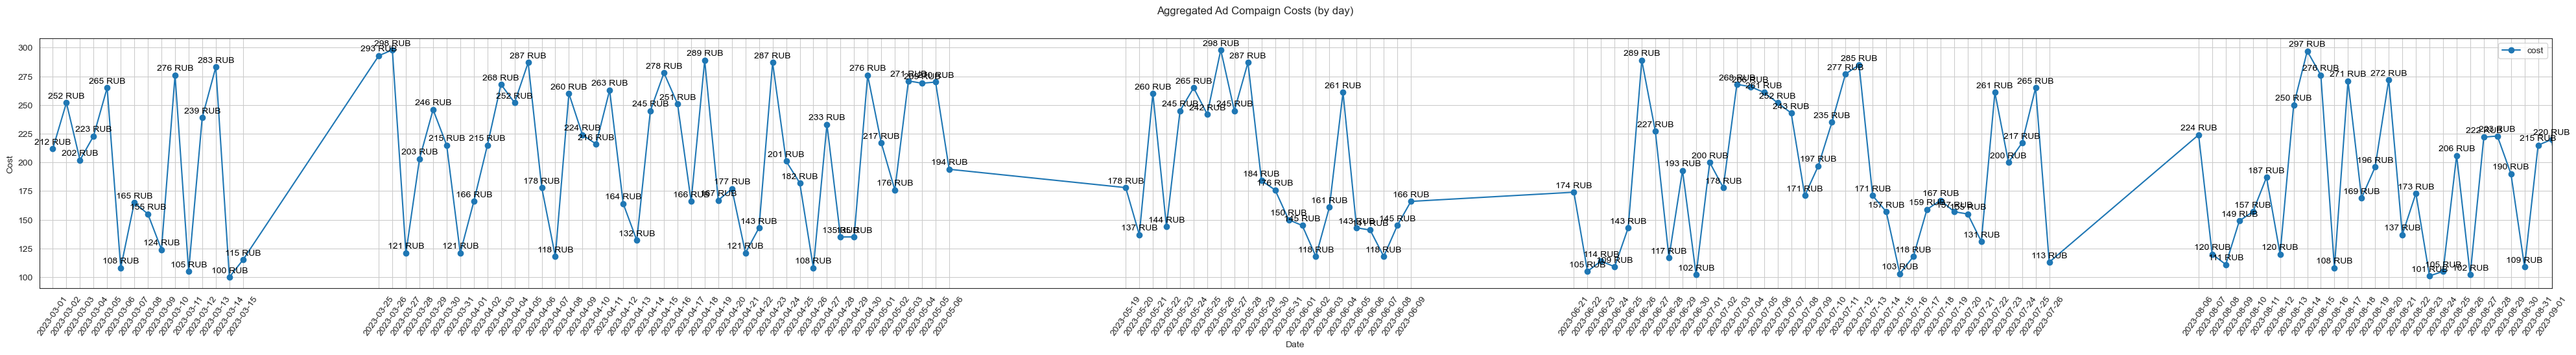

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches((50, 5))
fig.suptitle("Aggregated Ad Compaign Costs (by day)")

ax.grid()
x = ads_cost['date_group']
y = ads_cost['cost']
ax.plot(x, y, data=ads_cost, marker='o')
ax.set_xticks(ads_cost['date_group'])
ax.set_xlim(left=start_date, right=end_date)

plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation = 55)
plt.legend()

for index, row in ads_cost.iterrows():
    ax.annotate(
        text=f"{int(row['cost'])} RUB",
        xy=(row['date_group'], row['cost']),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        color='black'
    )

plt.savefig('./charts/ads_cost.png')

### Графики визитов и регистраций с выделением рекламных компаний

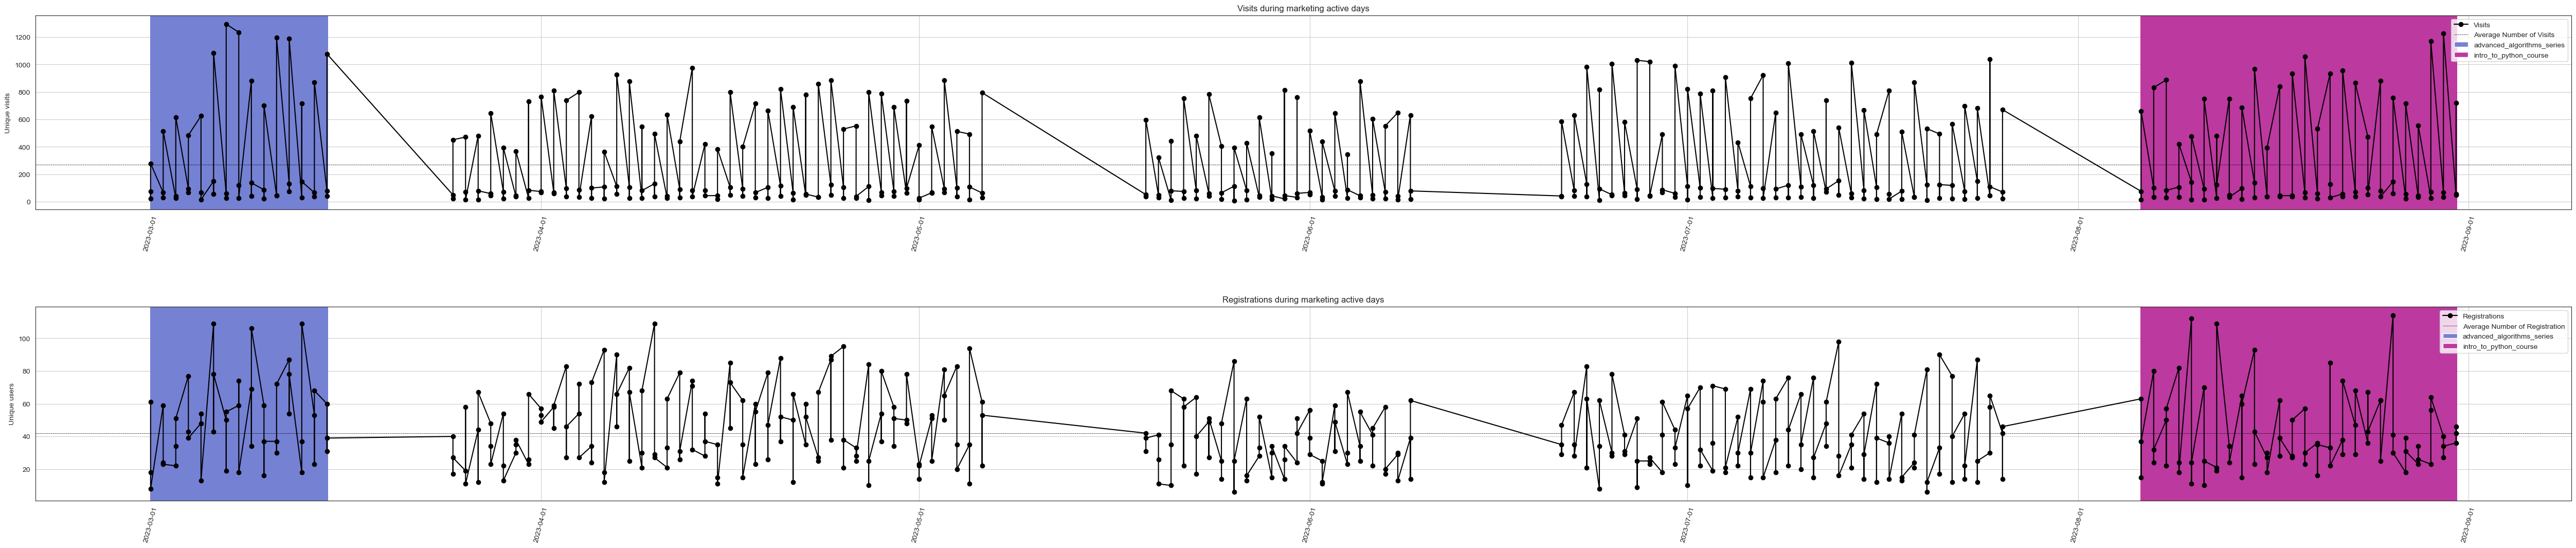

In [16]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches((50, 10))
plt.tight_layout()

dictionary_ads = {
    0: (ads_merged['visits'], "Visits during marketing active days", "Visits", "Unique visits", 'Average Number of Visits', 'black'),
    1: (ads_merged['registrations'], "Registrations during marketing active days", "Registrations", "Unique users", 'Average Number of Registration', 'black'),
}

color_dict = {}
legend_elements = []
excluded_campaigns = {"virtual_reality_workshop", "ui_ux_design_drive", "women_in_tech_symposium"}
for n in range(2):
    ads, ads_title, ads_label, ads_y_label, ads_mean, ads_color = dictionary_ads[n]
    x = 'date_group'
    y = ads
    #ax[n].plot(x, y, data=ads_merged, label=ads_label, marker='o', color=ads_color)
    #ax[n].set_ylabel(ads_y_label)
    #ax[n].set_title(ads_title)
    #ax[n].set_xticks(ax[n].get_xticks())
    #ax[n].set_xlim(left=start_date, right=end_date)
    #ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=75)
    #ax[n].axhline(ads.mean(), color='black', linestyle='--', linewidth=0.5, label=ads_mean)
    
    plot_line, = ax[n].plot(x, y, data=ads_merged, marker='o', color=ads_color, label=ads_label)
    mean_line = ax[n].axhline(ads.mean(), color='black', linestyle='--', linewidth=0.5, label=ads_mean)
    ax[n].set_ylabel(ads_y_label)
    ax[n].set_title(ads_title)
    ax[n].set_xticks(ax[n].get_xticks())
    #ax[n].set_xlim(left=ads_merged['min_date_group'].min(), right=ads_merged['max_date_group'].max())
    ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=75)

    for _, row in ads_merged.iterrows():
        campaign = row['utm_campaign']
        if campaign and campaign not in excluded_campaigns:
            if campaign not in color_dict:
                color = np.random.rand(3,)
                color_dict[campaign] = color
                legend_elements.append(Patch(facecolor=color, edgecolor='w', label=campaign))
            ax[n].axvspan(row['min_date_group'], row['max_date_group'], color=color_dict[campaign], alpha=0.5)
    handles, labels = ax[n].get_legend_handles_labels()

    handles += legend_elements
    labels += [patch.get_label() for patch in legend_elements]

    ax[n].legend(handles=handles, labels=labels, loc='upper right')
    ax[n].grid()
    #for _, row in ads_merged.iterrows():
        #ax[n].axvspan(row['min_date_group'], row['max_date_group'], color=np.random.rand(3,), alpha=0.5, 
        #label=row['utm_campaign'])
        
    #ax[n].legend()
    #ax[n].grid()  
plt.subplots_adjust(hspace=0.5)
plt.savefig('./charts/ads_visits_registrations.png')